# Planning the spanish economy 

Let's begin importing the data in a dictionary for the periods we want to plan. The data has been saved from the excel files using the ``save_data.py`` script.

In [1]:
from sys import path
from os.path import join, abspath
from pickle import load

# Tell python to search for the files and modules starting from the working directory
module_path = abspath(join('..', '..'))
if module_path not in path:
    path.append(module_path)

with open(join('data', 'spanish_economy.pkl'), 'rb') as f:
    economy = load(f)

with open(join('data', 'spanish_product_names.pkl'), 'rb') as f:
    product_names, activity_names = load(f)

The products and production units are the same since the data is aggregated (except there is a CO2 product but not a CO2 sector):

In [2]:
product_names.head()

,Unnamed: 1
0,1. Products of agriculture
1,2. Live animals and animal products
2,3. Agricultural and animal husbandry services
3,"4. Products of forestry, logging and related s..."
4,5 .Fish and other fishing products; aquacultur...


In [3]:
product_names.tail()

,Unnamed: 1
105,106. Services furnished by membership organisa...
106,107. Repair services of computers and personal...
107,108. Other personal services
108,109. Services of households as employers; undi...
109,110. Services provided by extraterritorial org...


In [4]:
activity_names.head()

,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,...,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,Unnamed: 77,Unnamed: 78,Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82
0,"Crop and animal production, hunting and relate...",Forestry and logging,Fishing and aquaculture,Mining and quarrying,Processing and preserving of meat and producti...,Manufacture of dairy products,Manufacture of other food products,Fabricación de bebidas,Manufacture of tobacco products,Manufacture of textiles,...,Education,Human health activities,Social work activities,"Creative, arts and entertainment activities; l...",Sports activities and amusement and recreation...,Activities of membership organisations,Repair of computers and personal and household...,Other personal service activities,Activities of households as employers; undiffe...,Activities of extra-territorial organisations ...


## The plan

We will plan the economy for 15 periods with a horizon of 5 periods and revising the plan after 3 periods (apply these 3 periods and discard the other 2).

In [11]:
from economicplanning import OptimizePlan
from numpy import zeros, ones

plan_periods = 5
horizon_periods = 2
revise_periods = 1

plan = OptimizePlan(plan_periods = plan_periods,
                    horizon_periods = horizon_periods, 
                    revise_periods = revise_periods,
                    econ = economy,
                    constraints_dict = {"export_constraints": False})

num_products = economy['export_prices'][0].size
# ! Problem is init_excess_prod is too low!!
init_excess_prod = 2 * economy['target_output'][0] + 2 * economy['imported_prod'][0]
init_export_deficit = 0

plan(init_excess_prod, init_export_deficit)


## Visualizing the results

In [12]:
import matplotlib.pyplot as plt
from numpy import linspace

plt.style.use('seaborn-v0_8-whitegrid')

colors = plt.cm.nipy_spectral(linspace(0, 1, num_products))

We planned for 9 years and the interpolation between them (mYEAR).

In [13]:
periods = ['2016', 'm2016', '2017', 'm2017', '2018', 'm2018', '2019']

### Production unit activity 

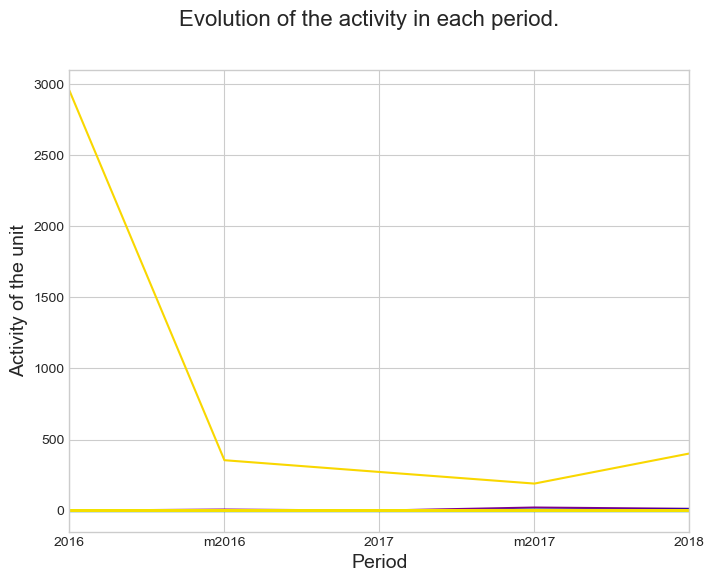

In [14]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
fig.suptitle('Evolution of the activity in each period.', size = 16)

for i in range(plan.num_units):
    ax.plot(periods[: plan.plan_periods], plan.planned_activity[i, :], c=colors[i, :])

plan_lims = ax.set_xlim(periods[0], periods[plan.plan_periods - 1])
ax.set_xlabel('Period', size = 14)
ax.set_ylabel('Activity of the unit', size = 14)

plt.savefig(join('figures', 'unit_activity.png'))

### Production

Note that a period with negative production means that more product was used than supplied.

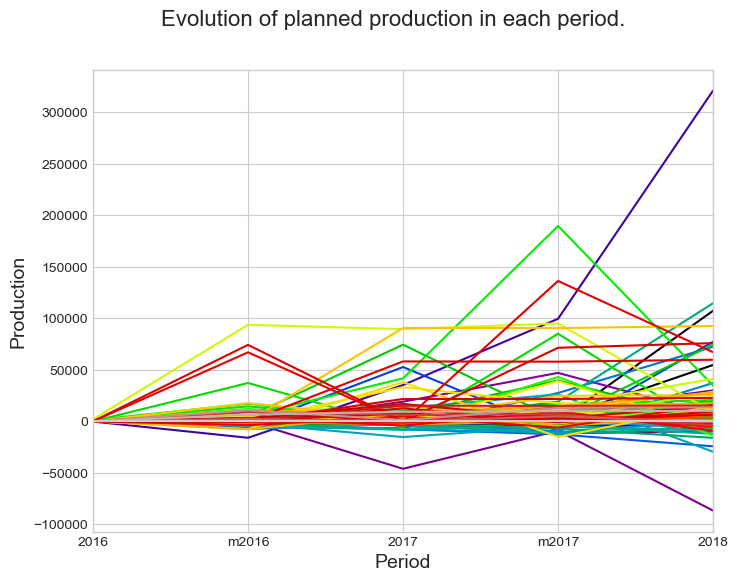

In [15]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
fig.suptitle('Evolution of planned production in each period.', size = 16)

for i in range(num_products):
    ax.plot(periods[: plan.plan_periods], plan.planned_prod[i, :], c=colors[i, :])

plan_lims = ax.set_xlim(periods[0], periods[plan.plan_periods - 1])
ax.set_xlabel('Period', size = 14)
ax.set_ylabel('Production', size = 14)

plt.savefig(join('figures', 'planned_prod.png'))

### Excess production

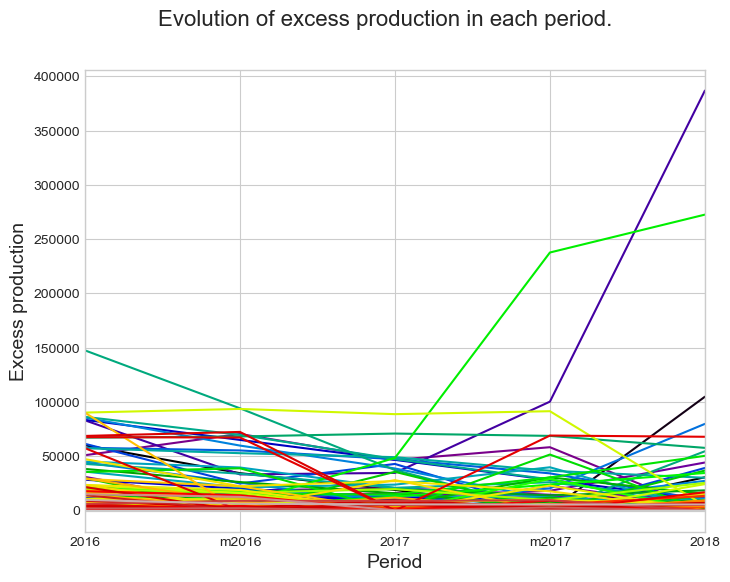

In [16]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
fig.suptitle('Evolution of excess production in each period.', size = 16)

for i in range(num_products):
    ax.plot(periods[: plan.plan_periods], plan.excess_prod[i, :], c=colors[i, :])

plan_lims = ax.set_xlim(periods[0], periods[plan.plan_periods - 1])
ax.set_xlabel('Period', size = 14)
ax.set_ylabel('Excess production', size = 14)

plt.savefig(join('figures', 'excess_prod.png'))

Note how carbon dioxide keeps rising since it is not used.

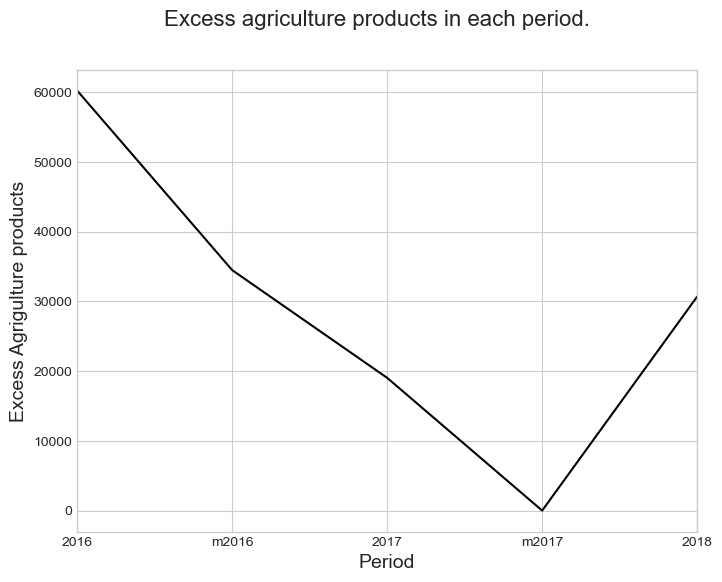

In [17]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
fig.suptitle(r'Excess agriculture products in each period.', size = 16)

ax.plot(periods[: plan.plan_periods], plan.excess_prod[0, :], c=colors[0, :])

plan_lims = ax.set_xlim(periods[0], periods[plan.plan_periods - 1])
ax.set_xlabel('Period', size = 14)
ax.set_ylabel("Excess Agrigulture products", size = 14)

plt.savefig(join('figures', 'excess_agriculture.png'))

### Total worked hours

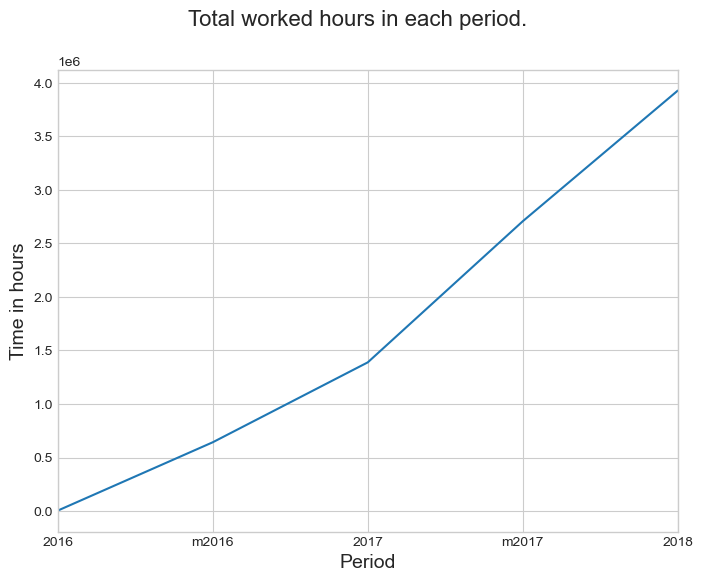

In [18]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
fig.suptitle('Total worked hours in each period.', size = 16)

ax.plot(periods[: plan.plan_periods], plan.worked_hours)

plan_lims = ax.set_xlim(periods[0], periods[plan.plan_periods - 1])
ax.set_xlabel('Period', size = 14)
ax.set_ylabel('Time in hours', size = 14)

plt.savefig(join('figures', 'worked_hours.png'))